In [1]:
import pandas as pd
import boto3
import sagemaker
from pyathena import connect
from scipy.stats import zscore
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
# Read in all necessary data

collision_df = pd.read_parquet('collision_data.parquet')
lost_df = pd.read_parquet('lost_objects.parquet')
satcat_df = pd.read_parquet('satcat.parquet')
esa_df = pd.read_parquet('full_esa.parquet')

In [6]:
# Change column to match with other datasets

lost_df['NORAD_CAT_ID_1'] = lost_df['NORAD Catalog Number'].apply(lambda x: x[:-2])
lost_df.drop(columns = 'NORAD Catalog Number', inplace = True)

# Merge collision df with satcat and esa to add more features

In [7]:
satcat_collision_combo = collision_df.merge(
    satcat_df, 
    how = 'inner', 
    left_on = 'NORAD_CAT_ID_1', 
    right_on = 'NORAD_CAT_ID',
    suffixes = ("", "_1")).drop(columns = "NORAD_CAT_ID")

In [8]:
full = satcat_collision_combo.merge(
    satcat_df,
    how = 'inner',
    left_on = 'NORAD_CAT_ID_2',
    right_on = 'NORAD_CAT_ID',
    suffixes = ("", "_2")
).drop(columns = ['NORAD_CAT_ID'])

In [12]:
# Drop unnecessary Features or repeats before next merge

more_to_drop = ['HAS_DECAYED', 'HAS_DECAYED_2', 'DECAY_DATE', 'DECAY_DATE_2', 'OBJECT_NAME', 
                'OBJECT_1_Active', 'OBJECT_2_Active', 'Activity_Status']

full.drop(columns = more_to_drop, inplace = True)

full.drop(columns = full.columns[-11], inplace = True)

In [9]:
esa_df.drop(columns = ['name', 'objectClass', 'firstEpoch'], inplace = True)

In [13]:
esa_combo = full.merge(
    esa_df,
    how = 'inner',
    left_on = 'OBJECT_ID',
    right_on = 'cosparId',
    suffixes = ("", "_1")
).drop(columns = 'cosparId')

In [14]:
esa_combo2 = esa_combo.merge(
    esa_df,
    how = 'inner',
    left_on = 'OBJECT_ID_2',
    right_on = 'cosparId',
    suffixes = ("", "_2")
).drop(columns = 'cosparId')

# Standardize columns

In [15]:
num_cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE', 'PERIOD_2', 'INCLINATION_2', 'APOGEE_2', 'PERIGEE_2']

In [16]:
full_standardized = esa_combo2.copy()

full_standardized[num_cols] = full[num_cols].apply(zscore)

In [17]:
full_standardized.to_parquet('full_standardized.parquet', index = False)

# Check outliers in target

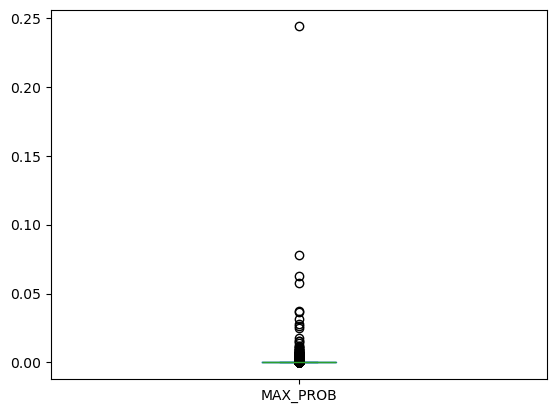

In [18]:
full_standardized['MAX_PROB'].plot(kind = 'box')

plt.show()

# Remove outliers and check again

In [19]:
IQR3 = full_standardized['MAX_PROB'].describe()['75%']

In [20]:
df_modeling = full_standardized[full_standardized['MAX_PROB'] <= IQR3]

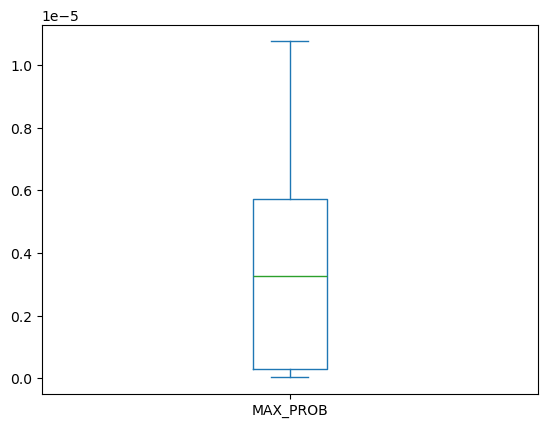

In [21]:
df_modeling['MAX_PROB'].plot(kind = 'box')

plt.show()

In [22]:
df_modeling.to_parquet("df_modeling.parquet", index = False)

In [2]:
df_modeling = pd.read_parquet('df_modeling.parquet')

# Start of modeling for full_standardized

In [23]:
autopilot_full_train_path = "./df_modeling.parquet"

In [24]:
train_s3_prefix = "cleaned_data"

In [25]:
autopilot_full_train_s3_uri = sess.upload_data(path = autopilot_full_train_path, key_prefix = train_s3_prefix)
autopilot_full_train_s3_uri

's3://sagemaker-us-east-1-662949783070/cleaned_data/df_modeling.parquet'

In [26]:
!aws s3 ls $autopilot_train_s3_uri

2025-03-20 17:52:14 sagemaker-studio-n502isf7dho
2025-03-20 17:52:16 sagemaker-us-east-1-662949783070


In [27]:
!aws s3 ls $autopilot_full_train_s3_uri

2025-03-31 19:59:47    3737957 df_modeling.parquet


In [28]:
%store autopilot_full_train_s3_uri

Stored 'autopilot_full_train_s3_uri' (str)


# Set up model path and job configuration

## Details about training job like instance

In [44]:
response = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName = 'automl-full-first28-16-56-14'
)

candidates = response['Candidates']

name = response['Candidates'][0]['CandidateName']

training_job = sm.describe_training_job(TrainingJobName = name)

training_job['ResourceConfig']['InstanceType']

In [29]:
prefix_model_output = "models/autopilot"

model_output_s3_uri = "s3://{}/{}".format(bucket, prefix_model_output)

print(model_output_s3_uri)

s3://sagemaker-us-east-1-662949783070/models/autopilot


In [57]:
# set up the training job

max_candidates = 3

job_config = {
    "CompletionCriteria": {
        "MaxRuntimePerTrainingJobInSeconds": 900,
        "MaxCandidates": max_candidates,
        "MaxAutoMLJobRuntimeInSeconds": 5400,
    },
}

input_data_config = [
    {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "{}".format(autopilot_full_train_s3_uri)}},
        "TargetAttributeName": "MAX_PROB",
        'ContentType': 'x-application/vnd.amazon+parquet'
    }
]

output_data_config = {"S3OutputPath": "{}".format(model_output_s3_uri)}
ProblemType = 'Regression'
AutoMLJobObjective = {'MetricName': 'RMSE'}

In [58]:
# check for any existing jobs

sm.list_auto_ml_jobs()

{'AutoMLJobSummaries': [{'AutoMLJobName': 'automl-full-second-30-22-28-17',
   'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-second-30-22-28-17',
   'AutoMLJobStatus': 'Completed',
   'AutoMLJobSecondaryStatus': 'Completed',
   'CreationTime': datetime.datetime(2025, 3, 30, 22, 28, 38, 826000, tzinfo=tzlocal()),
   'EndTime': datetime.datetime(2025, 3, 30, 22, 59, 8, 73000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2025, 3, 30, 22, 59, 8, 106000, tzinfo=tzlocal())},
  {'AutoMLJobName': 'automl-full-first28-16-56-14',
   'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-first28-16-56-14',
   'AutoMLJobStatus': 'Completed',
   'AutoMLJobSecondaryStatus': 'Completed',
   'CreationTime': datetime.datetime(2025, 3, 28, 17, 6, 26, 519000, tzinfo=tzlocal()),
   'EndTime': datetime.datetime(2025, 3, 28, 17, 38, 28, 289000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2025, 3, 28, 17, 38, 28, 3220

In [68]:
# This establishes the current ML job

from time import gmtime, strftime, sleep


%store -d  auto_ml_job_name
%store -r auto_ml_job_name

try:
    auto_ml_job_name
except NameError:
    timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
    auto_ml_job_name = "automl-full-third-" + timestamp_suffix
    print("Created AutoMLJobName: " + auto_ml_job_name)

no stored variable or alias auto_ml_job_name
Created AutoMLJobName: automl-full-third-31-20-34-21


In [69]:
sm.create_auto_ml_job(
    AutoMLJobName = auto_ml_job_name,
    InputDataConfig = input_data_config,
    OutputDataConfig = output_data_config,
    AutoMLJobConfig = job_config,
    RoleArn = role,
    ProblemType = 'Regression',
    AutoMLJobObjective = {'MetricName': 'RMSE'}
)

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-31-20-34-21',
 'ResponseMetadata': {'RequestId': '87a522d9-1d00-48da-b969-d29ce28bdcc0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '87a522d9-1d00-48da-b969-d29ce28bdcc0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Mon, 31 Mar 2025 20:34:29 GMT'},
  'RetryAttempts': 0}}

In [70]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while (
    "AutoMLJobStatus" not in job_description_response.keys()
    and "AutoMLJobSecondaryStatus" not in job_description_response.keys()
):
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet started. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for Autopilot Job to start...")
    sleep(15)

print("[OK] AutoMLJob started.")

[OK] AutoMLJob started.


In [71]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/">Processing Jobs</a></b>'.format(
            region
        )
    )
)

In [72]:
%%time

# Analyzing data and generating reports

job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]

if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("Starting", "AnalyzingData"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Data analysis phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
[OK] Data analysis phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-31-20-34-21",
    "AutoMLJobArtifacts": {
        "CandidateDefin

In [73]:
# check that aritifacts were generated

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while "AutoMLJobArtifacts" not in job_description_response.keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the artifacts. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for AutoMLJobArtifacts...")
    sleep(15)

print("[OK] AutoMLJobArtifacts generated.")

[OK] AutoMLJobArtifacts generated.


In [74]:
# Check that data exploration notebook was created

while "DataExplorationNotebookLocation" not in job_description_response["AutoMLJobArtifacts"].keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the notebooks. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for DataExplorationNotebookLocation...")
    sleep(15)

print("[OK] DataExplorationNotebookLocation found.")

[OK] DataExplorationNotebookLocation found.


In [75]:
# Save the above to paths

generated_resources = job_description_response["AutoMLJobArtifacts"]["DataExplorationNotebookLocation"]
download_path = generated_resources.rsplit("/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb")[0]
job_id = download_path.rsplit("/", 1)[-1]

In [76]:
from IPython.display import display, HTML

if not job_id:
    print("No AutoMLJobArtifacts found.")
else:
    display(
        HTML(
            '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/{}/sagemaker-automl-candidates/{}/">S3 Generated Resources</a></b>'.format(
                bucket, prefix_model_output, auto_ml_job_name, job_id
            )
        )
    )

In [77]:
print(download_path)

s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf


In [78]:
# Copy artifacts to workspace

try:
    !aws s3 cp --recursive $download_path .
except:
    print('Could not download the generated resources. Make sure the path is correct.')

download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/generated_module/MANIFEST.in to generated_module/MANIFEST.in
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/generated_module/candidate_data_processors/dpp1.py to generated_module/candidate_data_processors/dpp1.py
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/generated_module/README.md to generated_module/README.md
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/notebooks/sagemaker_automl/co

In [82]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/">Training Jobs</a></b>'.format(
            region
        )
    )
)

In [83]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/transform-jobs/">Batch Transform Jobs</a></b>'.format(
            region
        )
    )
)

In [81]:
%%time

# check progress of feature engineering

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("FeatureEngineering"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Feature engineering phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress

In [84]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/">Hyperparameter Tuning Jobs</a></b>'.format(
            region
        )
    )
)

In [85]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/">Training Jobs</a></b>'.format(
            region
        )
    )
)

In [86]:
%%time

#check progress of model tuning

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("ModelTuning"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Model tuning phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress MergingAutoMLTaskReports
[OK] Model tuning phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-31-20-34-21",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/sagemaker-automl-candidates/automl-full-third-31-20-34-21-pr-1-76f52846680944baa3ec61f3eacf/notebooks/SageMakerAutopilotDa

In [ ]:
%%time

# check to see when job is completed

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
print(job_status)
if job_status not in ("Stopped", "Failed"):
    while job_status not in ("Completed"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        print(job_status)
        sleep(10)
    print("[OK] Autopilot Job completed.\n")
else:
    print(job_status)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
[OK] Autopilot Job completed.

CPU times: user 277 ms, sys: 38.1 ms, total: 315 ms
Wall time: 11min 15s


In [92]:
candidates_response = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
)

print(candidates_response.keys())

dict_keys(['Candidates', 'ResponseMetadata'])


In [93]:
candidates = candidates_response['Candidates']
print(json.dumps(candidates, indent=4, sort_keys=True, default=str))

[
    {
        "CandidateName": "automl-full-third-31-20-34-21cZD-003-f53a7083",
        "CandidateProperties": {
            "CandidateMetrics": [
                {
                    "MetricName": "MAE",
                    "Set": "Validation",
                    "StandardMetricName": "MAE",
                    "Value": 0.0
                },
                {
                    "MetricName": "RMSE",
                    "Set": "Validation",
                    "StandardMetricName": "RMSE",
                    "Value": 0.0
                },
                {
                    "MetricName": "MSE",
                    "Set": "Validation",
                    "StandardMetricName": "MSE",
                    "Value": 0.0
                },
                {
                    "MetricName": "R2",
                    "Set": "Validation",
                    "StandardMetricName": "R2",
                    "Value": -0.22088000178337097
                }
            ]
        },
      

In [94]:
for index, candidate in enumerate(candidates):
    print(
        str(index)
        + "  "
        + candidate["CandidateName"]
        + "  "
        + str(candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    )

0  automl-full-third-31-20-34-21cZD-003-f53a7083  0.0
1  automl-full-third-31-20-34-21cZD-001-ffcf2804  0.0
2  automl-full-third-31-20-34-21cZD-002-3c87466e  0.0


In [95]:
# Get analytics and save dataframe

from sagemaker.analytics import ExperimentAnalytics, TrainingJobAnalytics

exp = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=auto_ml_job_name + "-aws-auto-ml-job",
)

df = exp.dataframe()

In [96]:
pd.set_option('display.max_columns', None)
df.head()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,colsample_bytree,eta,eval_metric,gamma,lambda,max_depth,min_child_weight,num_round,objective,save_model_on_termination,subsample,ObjectiveMetric - Min,ObjectiveMetric - Max,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count,train:rmse - Min,train:rmse - Max,train:rmse - Avg,train:rmse - StdDev,train:rmse - Last,train:rmse - Count,train:mae - Min,train:mae - Max,train:mae - Avg,train:mae - StdDev,train:mae - Last,train:mae - Count,train:mse - Min,train:mse - Max,train:mse - Avg,train:mse - StdDev,train:mse - Last,train:mse - Count,validation:mse - Min,validation:mse - Max,validation:mse - Avg,validation:mse - StdDev,validation:mse - Last,validation:mse - Count,validation:mae - Min,validation:mae - Max,validation:mae - Avg,validation:mae - StdDev,validation:mae - Last,validation:mae - Count,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,validation:rmse - StdDev,validation:rmse - Last,validation:rmse - Count,validation:r2 - Min,validation:r2 - Max,validation:r2 - Avg,validation:r2 - StdDev,validation:r2 - Last,validation:r2 - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments,SageMaker.ModelName,SageMaker.ModelPrimary.DataUrl,SageMaker.ModelPrimary.Image,SageMaker.TransformInput - MediaType,SageMaker.TransformInput - Value,SageMaker.TransformOutput - MediaType,SageMaker.TransformOutput - Value,processor_module,sagemaker_program,sagemaker_submit_directory,code - MediaType,code - Value,auto_ml_job_arn,content_type,enable_stratified_split,enable_validation_split,input_channel_mode,job_name,label_col,max_dataset_size,max_subsampled_dataset_size,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,ds - MediaType,ds - Value
0,automl-full-third-31-20-34-21cZD-002-3c87466e-...,automl-full-third-31-20-34-21cZD-002-3c87466e-...,arn:aws:sagemaker:us-east-1:662949783070:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.12xlarge,50.0,validation:rmse,0.060197,0.302867,0.132497,"mse,mae,rmse,r2",0.000023,0.000073,3.0,0.000001,709.0,reg:squarederror,true,0.879007,0.0,0.43375,0.0,0.0,0.0,0.0,0.0,0.43375,0.0,0.0,0.0,0.0,0.0,0.43375,0.0,0.0,0.0,0.0,0.0,0.18814,0.0,0.0,0.0,0.0,0.0,0.18814,0.0,0.0,0.0,0.0,0.0,0.43375,0.0,0.0,0.0,0.0,0.0,0.43375,0.0,0.0,0.0,0.0,-2.002550e+10,0.0,0.0,0.0,-0.22088,0.0,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,NaN,s3://sagemaker-us-east-1-662949783070/models/a...,[automl-full-third-31-20-34-21cZD-002-3c87466e...,[automl-full-third-31-20-34-21-aws-auto-ml-job],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,automl-full-third-31-20-34-21cZD-001-ffcf2804-...,automl-full-third-31-20-34-21cZD-001-ffcf2804-...,arn:aws:sagemaker:us-east-1:662949783070:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.12xlarge,50.0,validation:rmse,0.000019,0.305443,0.045021,"mse,mae,rmse,r2",0.002444,0.250783,2.0,0.000005,557.0,reg:squarederror,true,0.530562,0.0,0.47749,0.0,0.0,0.0,0.0,0.0,0.47749,0.0,0.0,0.0,0.0,0.0,0.47749,0.0,0.0,0.0,0.0,0.0,0.22799,0.0,0.0,0.0,0.0,0.0,0.22799,0.0,0.0,0.0,0.0,0.0,0.47749,0.0,0.0,0.0,0.0,0.0,0.47749,0.0,0.0,0.0,0.0,-2.426771e+10,0.0,0.0,0.0,-0.00004,0.0,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,NaN,s3://sagemaker-us-east-1-662949783070/models/a...,[automl-full-third-31-20-34-21cZD-001-ffcf2804...,[automl-full-third-31-20-34-21-aws-auto-ml-job],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [111]:
path = "{}.csv".format(auto_ml_job_name)
df.to_csv(path, index = False)

In [97]:
best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']

In [110]:
best_candidate_name = best_candidate_response['CandidateName']

'automl-full-third-31-20-34-21cZD-001-ffcf2804'

In [98]:
print(best_candidate_response.keys())

dict_keys(['CandidateName', 'FinalAutoMLJobObjectiveMetric', 'ObjectiveStatus', 'CandidateSteps', 'CandidateStatus', 'InferenceContainers', 'CreationTime', 'EndTime', 'LastModifiedTime', 'CandidateProperties'])


In [99]:
best_can_name = best_candidate_response['CandidateName']

In [100]:
steps = []
for step in best_candidate_response["CandidateSteps"]:
    print("Candidate Step Type: {}".format(step["CandidateStepType"]))
    print("Candidate Step Name: {}".format(step["CandidateStepName"]))
    steps.append(step["CandidateStepName"])

Candidate Step Type: AWS::SageMaker::ProcessingJob
Candidate Step Name: automl-full-third-31-20-34-21-db-1-9a299a547a4c432c93fd88542fa0
Candidate Step Type: AWS::SageMaker::TrainingJob
Candidate Step Name: automl-full-third-31-20-34-21-dpp2-1-420bc963b8734cd9a18536d5d1
Candidate Step Type: AWS::SageMaker::TransformJob
Candidate Step Name: automl-full-third-31-20-34-21-dpp2-rpb-1-68e0a643bb0b48d0897fd6
Candidate Step Type: AWS::SageMaker::TrainingJob
Candidate Step Name: automl-full-third-31-20-34-21cZD-001-ffcf2804


In [101]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review Best Candidate <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, steps[0]
        )
    )
)

In [102]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review Best Candidate <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a></b>'.format(
            region, steps[1]
        )
    )
)

In [90]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review All <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=models/autopilot/{}/">Output in S3</a></b>'.format(
            bucket, region, auto_ml_job_name
        )
    )
)

In [103]:
best_can_containers = best_candidate_response['InferenceContainers']

In [104]:
best_can_containers

[{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-sklearn-automl:2.5-1-cpu-py3',
  'ModelDataUrl': 's3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/data-processor-models/automl-full-third-31-20-34-21-dpp2-1-420bc963b8734cd9a18536d5d1/output/model.tar.gz',
  'Environment': {'AUTOML_SPARSE_ENCODE_RECORDIO_PROTOBUF': '1',
   'AUTOML_TRANSFORM_MODE': 'feature-transform',
   'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'application/x-recordio-protobuf',
   'SAGEMAKER_PROGRAM': 'sagemaker_serve',
   'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code'}},
 {'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3',
  'ModelDataUrl': 's3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/tuning/automl-ful-dpp2-xgb/automl-full-third-31-20-34-21cZD-001-ffcf2804/output/model.tar.gz',
  'Environment': {'MAX_CONTENT_LENGTH': '20971520',
   'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv'}}]

In [105]:
for container in best_can_containers:
    print(container["Environment"])
    print("======================")

{'AUTOML_SPARSE_ENCODE_RECORDIO_PROTOBUF': '1', 'AUTOML_TRANSFORM_MODE': 'feature-transform', 'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'application/x-recordio-protobuf', 'SAGEMAKER_PROGRAM': 'sagemaker_serve', 'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code'}
{'MAX_CONTENT_LENGTH': '20971520', 'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv'}


In [106]:
best_can_containers[0]["Environment"].update({"SAGEMAKER_INFERENCE_OUTPUT": "predicted_label, probability"})
best_can_containers[1]["Environment"].update({"SAGEMAKER_INFERENCE_INPUT": "predicted_label, probability"})
best_can_containers[1]["Environment"].update({"SAGEMAKER_INFERENCE_OUTPUT": "predicted_label, probability"})

In [108]:
#Check out what's in the bucket

!aws s3 cp "s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/documentation/" ./automl-docs --recursive

download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/documentation/explainability/config/analysis_config.json to automl-docs/explainability/config/analysis_config.json
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-31-20-34-21/documentation/explainability/config/analysis_config_pdp.json to automl-docs/explainability/config/analysis_config_pdp.json
